# Calculations -- Changes in variables over monsoon domain
This section calcualte and plot relative changes (midHolocene - piControl) in monsoonover North America Monsoon System (NAMS), North Afraca (NAF),Southern Asia (SAS) and East Asia summer (EAS) in the Northern Hemisphere and South America Monsoon System (SAMS), South Africa(SAF) and Australian-Maritime Continent (AUSMC) in the Southern Hemisphere, in averaged precipitation (Pav), standard deviation of av-eraged precipitation (Psv), averaged area of monsoon domain (Aav), standard deviation of averaged Area (Asv) and total annual precipitaion(totwater). 

* Mondoon data loaded in here are raw precipitaion date averaged over the monsoon domian determined by each model at the corresponding year.

* Due to the lack of data, this part uses midHolocene data.

In [2]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy

In [2]:
#Define monsoon names
monsoonlist=['NAF','EAS','AUSMC','NAMS','SAF','SAMS','SAS',]

In [3]:
pmip_v3='PMIP3'
pmip_v4='PMIP4'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NorESM1-F',
               'NorESM2',
               'NESM3',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  






In [4]:
#No change needs here

'''Define calculating functions, same as in Ensemble one with slight changes applied to fit monsoon calculations'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


In [5]:
#This function calculates the changes (midHolocene - piControl) in individual monsoon for each model
def monsoon_cal(monsoon_name,experiment_name,pmip_v):
    model_list=[]
    data={}
    rainfall_name='monsoon_rain_%s' %monsoon_name
    area_name='monsoon_area_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_rain=expt_a_file[rainfall_name]
                expt_mean_rain=np.nanmean(expt_rain)
                expt_std_rain=np.nanstd(expt_rain)
                expt_area=expt_a_file[area_name]
                expt_mean_area=np.nanmean(expt_area)
                expt_std_area=np.nanstd(expt_area)
                expt_water=expt_rain*expt_area
                expt_mean_water=np.nanmean(expt_water)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_mean_rain=np.nanmean(pi_rain)
                pi_std_rain=np.nanstd(pi_rain)
                pi_area=expt_b_file[area_name]
                pi_mean_area=np.nanmean(pi_area)
                pi_std_area=np.nanstd(pi_area)
                pi_water=pi_rain*pi_area
                pi_mean_water=np.nanmean(pi_water)
                pav=(expt_mean_rain-pi_mean_rain)*100/pi_mean_rain
                psd=(expt_std_rain-pi_std_rain)*100/pi_std_rain
                aav=(expt_mean_area-pi_mean_area)*100/pi_mean_area
                asd=(expt_std_area-pi_std_area)*100/pi_std_area
                water=(expt_mean_water-pi_mean_water)*100/pi_mean_water
                data[gcm]=[pav,psd,aav,asd,water]
    f3='model_lists/%s_%s_modellist.csv' %(pmip_v,monsoon_name)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    f4='plotting_data/%s_%s.csv' %(pmip_v,monsoon_name)
    da=pd.DataFrame(data)
    da.to_csv(f4)
    return model_list,data







In [ ]:
experiment_name='midHolocene' #define experiment
#This step use NAF as a sample to generate model lists
monsoon_name='NAF'
model_list3,data3=monsoon_cal(monsoon_name,experiment_name,pmip_v3)
model_list4,data4=monsoon_cal(monsoon_name,experiment_name,pmip_v4)

In [ ]:
#This cell creates directories to store results
pav_data4={}
psd_data4={}
aav_data4={}
asd_data4={}
water_data4={}
for m in model_list4:
    pav_data4[m]=[]
    psd_data4[m]=[]
    aav_data4[m]=[]
    asd_data4[m]=[]
    water_data4[m]=[]
    
pav_data3={}
psd_data3={}
aav_data3={}
asd_data3={}
water_data3={}
for m in model_list3:
    pav_data3[m]=[]
    psd_data3[m]=[]
    aav_data3[m]=[]
    asd_data3[m]=[]
    water_data3[m]=[]

In [ ]:
#Calculations
#PMIP4
for monsoon_name in monsoonlist:
    model_list4,data4=monsoon_cal(monsoon_name,experiment_name,pmip_v4)
    for m in model_list4:
        pav_data4[m].append(data4[m][0])
        psd_data4[m].append(data4[m][1])
        aav_data4[m].append(data4[m][2])
        asd_data4[m].append(data4[m][3])
        water_data4[m].append(data4[m][4])
#PMIP3    
for monsoon_name in monsoonlist:
    model_list3,data3=monsoon_cal(monsoon_name,experiment_name,pmip_v3)
    for m in model_list3:
        pav_data3[m].append(data3[m][0])
        psd_data3[m].append(data3[m][1])
        aav_data3[m].append(data3[m][2])
        asd_data3[m].append(data3[m][3])
        water_data3[m].append(data3[m][4])
    


In [ ]:
#This cell calculates and stores ensemble averages
pmip3mean={}

var=['pav','psd','aav','asd','totwater']
for v in var:
    f='plotting_data/pmip3_%s.csv'%v
    df= pd.read_csv(f,skipinitialspace=True,header=0)
    pmip3mean[v]=df['average']


pmip4mean={}

var=['pav','psd','aav','asd','totwater']
for v in var:
    f='plotting_data/pmip4_%s.csv'%v
    df= pd.read_csv(f,skipinitialspace=True,header=0)
    pmip4mean[v]=df['average']




In [ ]:
pav3=[]
psd3=[]
aav3=[]
asd3=[]
totwater=[]
for m in model_list3:
    pav3.append(pav_data3[m])

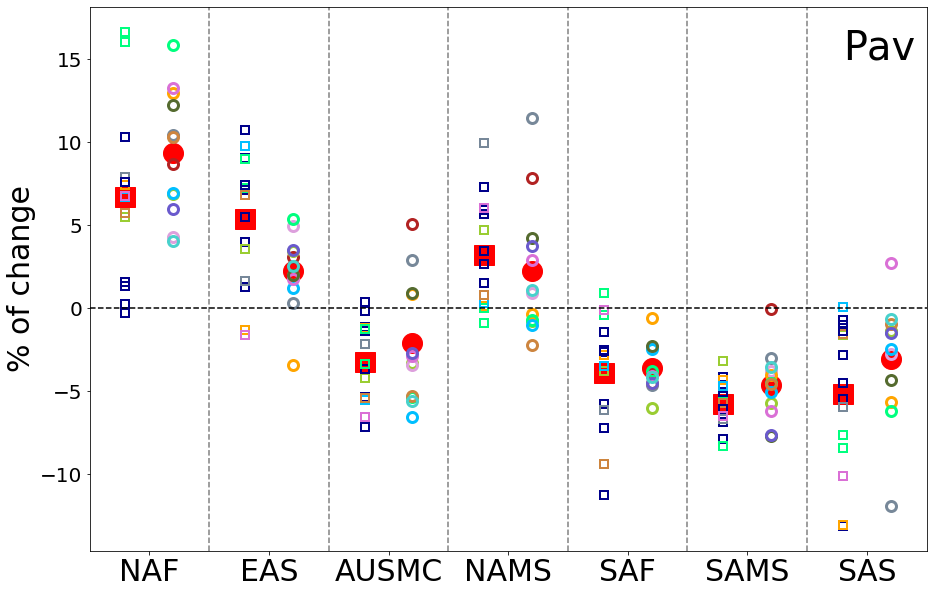

In [46]:
p1=[0.3,1.3,2.3,3.3,4.3,5.3,6.3]
p2=[0.7,1.7,2.7,3.7,4.7,5.7,6.7]
p3=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
lines=[1,2,3,4,5,6]
var=monsoonlist
colorst =['firebrick','yellowgreen','plum','lightslategray','orange','springgreen','deepskyblue','peru','orchid','darkolivegreen','slateblue','mediumturquoise']
colorst3=['darkblue','yellowgreen','darkblue','darkblue','darkblue','darkblue','lightslategray','darkblue','orange','springgreen','springgreen','deepskyblue','peru','darkblue','orchid']

plt.figure(figsize=(15,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.plot(p1,pmip3mean['pav'],marker='s', color='r',ms=20,linestyle='None')
for i in range(len(model_list3)):
    plt.plot(p1,pav_data3[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')


plt.plot(p2,pmip4mean['pav'],marker='o',color='r',ms=20,linestyle='None')
for i in range(len(model_list4)):
    plt.plot(p2,pav_data4[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])

plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
plt.text(6.3,15,'Pav',fontsize=40)

for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")
plt.savefig('figs/Pav_mean.png')

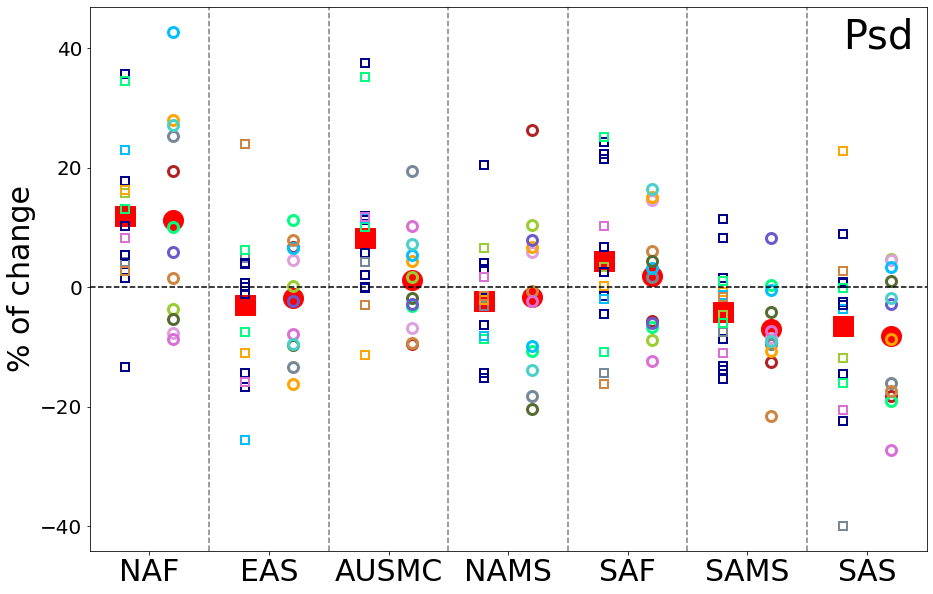

In [50]:
plt.figure(figsize=(15,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.plot(p1,pmip3mean['psd'],marker='s', color='r',ms=20,linestyle='None')
for i in range(len(model_list3)):
    plt.plot(p1,psd_data3[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p2,pmip4mean['psd'],marker='o', color='r',ms=20,linestyle='None')
for i in range(len(model_list4)):
    plt.plot(p2,psd_data4[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.ylabel('% of change',fontsize=30)
plt.xticks(p3,var,fontsize=30)

plt.text(6.3,40,'Psd',fontsize=40)
#leg=plt.legend(edgecolor='None',facecolor='None')
#for line, text in zip(leg.get_lines(), leg.get_texts()):
#    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")
plt.savefig('figs/Psd_mean.png')

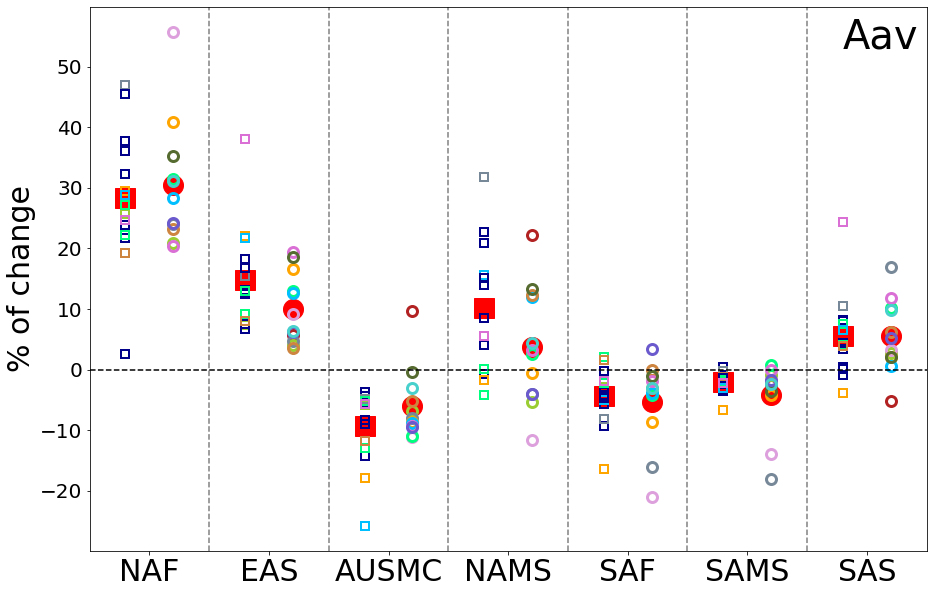

In [53]:
p1=[0.3,1.3,2.3,3.3,4.3,5.3,6.3]
p2=[0.7,1.7,2.7,3.7,4.7,5.7,6.7]
p3=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
lines=[1,2,3,4,5,6]
var=monsoonlist
colorst =['firebrick','yellowgreen','plum','lightslategray','orange','springgreen','deepskyblue','peru','orchid','darkolivegreen','slateblue','mediumturquoise']
colorst3=['darkblue','yellowgreen','darkblue','darkblue','darkblue','darkblue','lightslategray','darkblue','orange','springgreen','springgreen','deepskyblue','peru','darkblue','orchid']



plt.figure(figsize=(15,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.plot(p1,pmip3mean['aav'],marker='s', color='r',ms=20,linestyle='None')
plt.plot(p2,pmip4mean['aav'],marker='o', color='r',ms=20,linestyle='None')
for i in range(len(model_list3)):
    plt.plot(p1,aav_data3[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')

for i in range(len(model_list4)):
    plt.plot(p2,aav_data4[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])

plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)

plt.text(6.3,53,'Aav',fontsize=40)
#leg=plt.legend(edgecolor='None',facecolor='None')
#for line, text in zip(leg.get_lines(), leg.get_texts()):
#    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")    
plt.savefig('figs/Aav_mean.png')

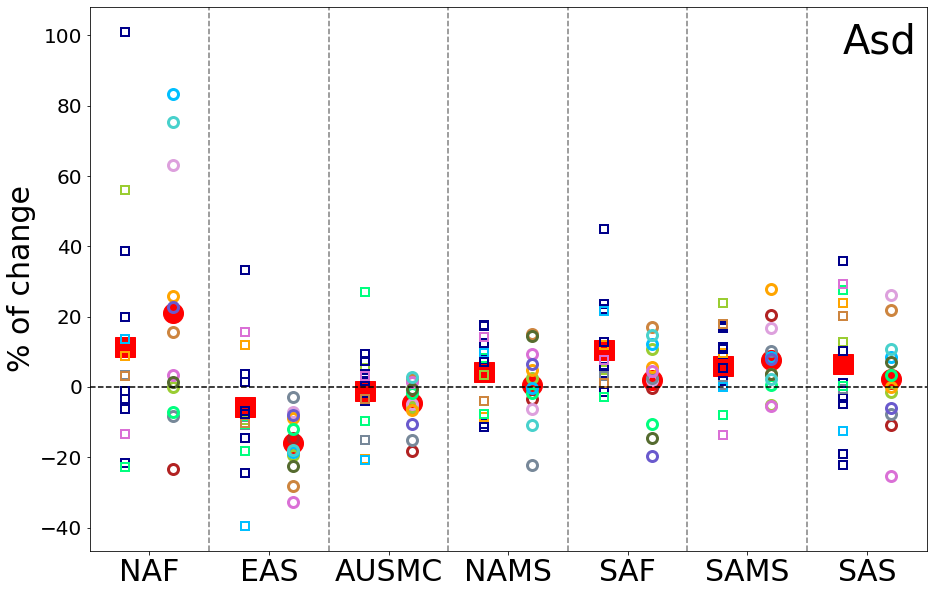

In [54]:
plt.figure(figsize=(15,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.plot(p1,pmip3mean['asd'],marker='s', color='r',ms=20,linestyle='None')
plt.plot(p2,pmip4mean['asd'],marker='o', color='r',ms=20,linestyle='None')
for i in range(len(model_list3)):
    plt.plot(p1,asd_data3[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
for i in range(len(model_list4)):
    plt.plot(p2,asd_data4[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])

plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
plt.text(6.3,95,'Asd',fontsize=40)

#leg=plt.legend(edgecolor='None',facecolor='None')
#for line, text in zip(leg.get_lines(), leg.get_texts()):
#    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")    
plt.savefig('figs/Asd_mean.png')

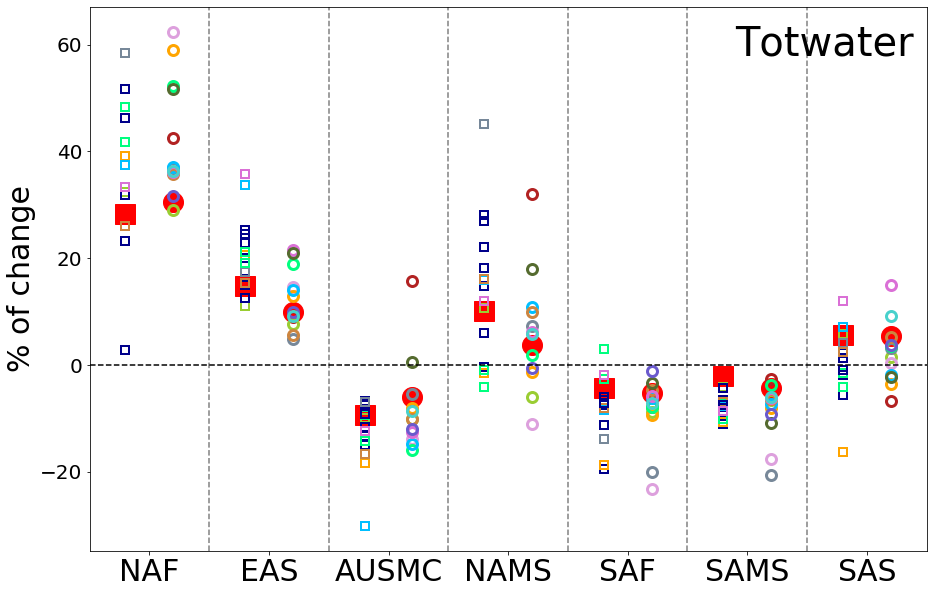

In [55]:
plt.figure(figsize=(15,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.plot(p1,pmip3mean['aav'],marker='s', color='r',ms=20,linestyle='None')
plt.plot(p2,pmip4mean['aav'],marker='o', color='r',ms=20,linestyle='None')
for i in range(len(model_list3)):
    plt.plot(p1,water_data3[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')


for i in range(len(model_list4)):
    plt.plot(p2,water_data4[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])

plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)

plt.text(5.4,58,'Totwater',fontsize=40)
#leg=plt.legend(edgecolor='None',facecolor='None')
#for line, text in zip(leg.get_lines(), leg.get_texts()):
 #   text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")    
plt.savefig('figs/totwater_mean.png')

In [ ]:
# Making the individual monsoon figure for midHolocene paper

In [5]:
df4pav= pd.read_excel('plotting_data/PMIP4_MH_monsoon.xlsx',sheet_name='pav',skipinitialspace=True,header=0)
df4psd= pd.read_excel('plotting_data/PMIP4_MH_monsoon.xlsx',sheet_name='psd',skipinitialspace=True,header=0)
df4aav= pd.read_excel('plotting_data/PMIP4_MH_monsoon.xlsx',sheet_name='aav',skipinitialspace=True,header=0)
df4asd= pd.read_excel('plotting_data/PMIP4_MH_monsoon.xlsx',sheet_name='asd',skipinitialspace=True,header=0)
df4water= pd.read_excel('plotting_data/PMIP4_MH_monsoon.xlsx',sheet_name='totwater',skipinitialspace=True,header=0)

df3pav= pd.read_excel('plotting_data/PMIP3_MH_monsoon.xlsx',sheet_name='pav',skipinitialspace=True,header=0)
df3psd= pd.read_excel('plotting_data/PMIP3_MH_monsoon.xlsx',sheet_name='psd',skipinitialspace=True,header=0)
df3aav= pd.read_excel('plotting_data/PMIP3_MH_monsoon.xlsx',sheet_name='aav',skipinitialspace=True,header=0)
df3asd= pd.read_excel('plotting_data/PMIP3_MH_monsoon.xlsx',sheet_name='asd',skipinitialspace=True,header=0)
df3water= pd.read_excel('plotting_data/PMIP3_MH_monsoon.xlsx',sheet_name='totwater',skipinitialspace=True,header=0)



model_list4=pd.read_csv('model_lists/PMIP4.csv',skipinitialspace=True,header=0)['0']
model_list3=pd.read_csv('model_lists/PMIP3.csv',skipinitialspace=True,header=0)['0']

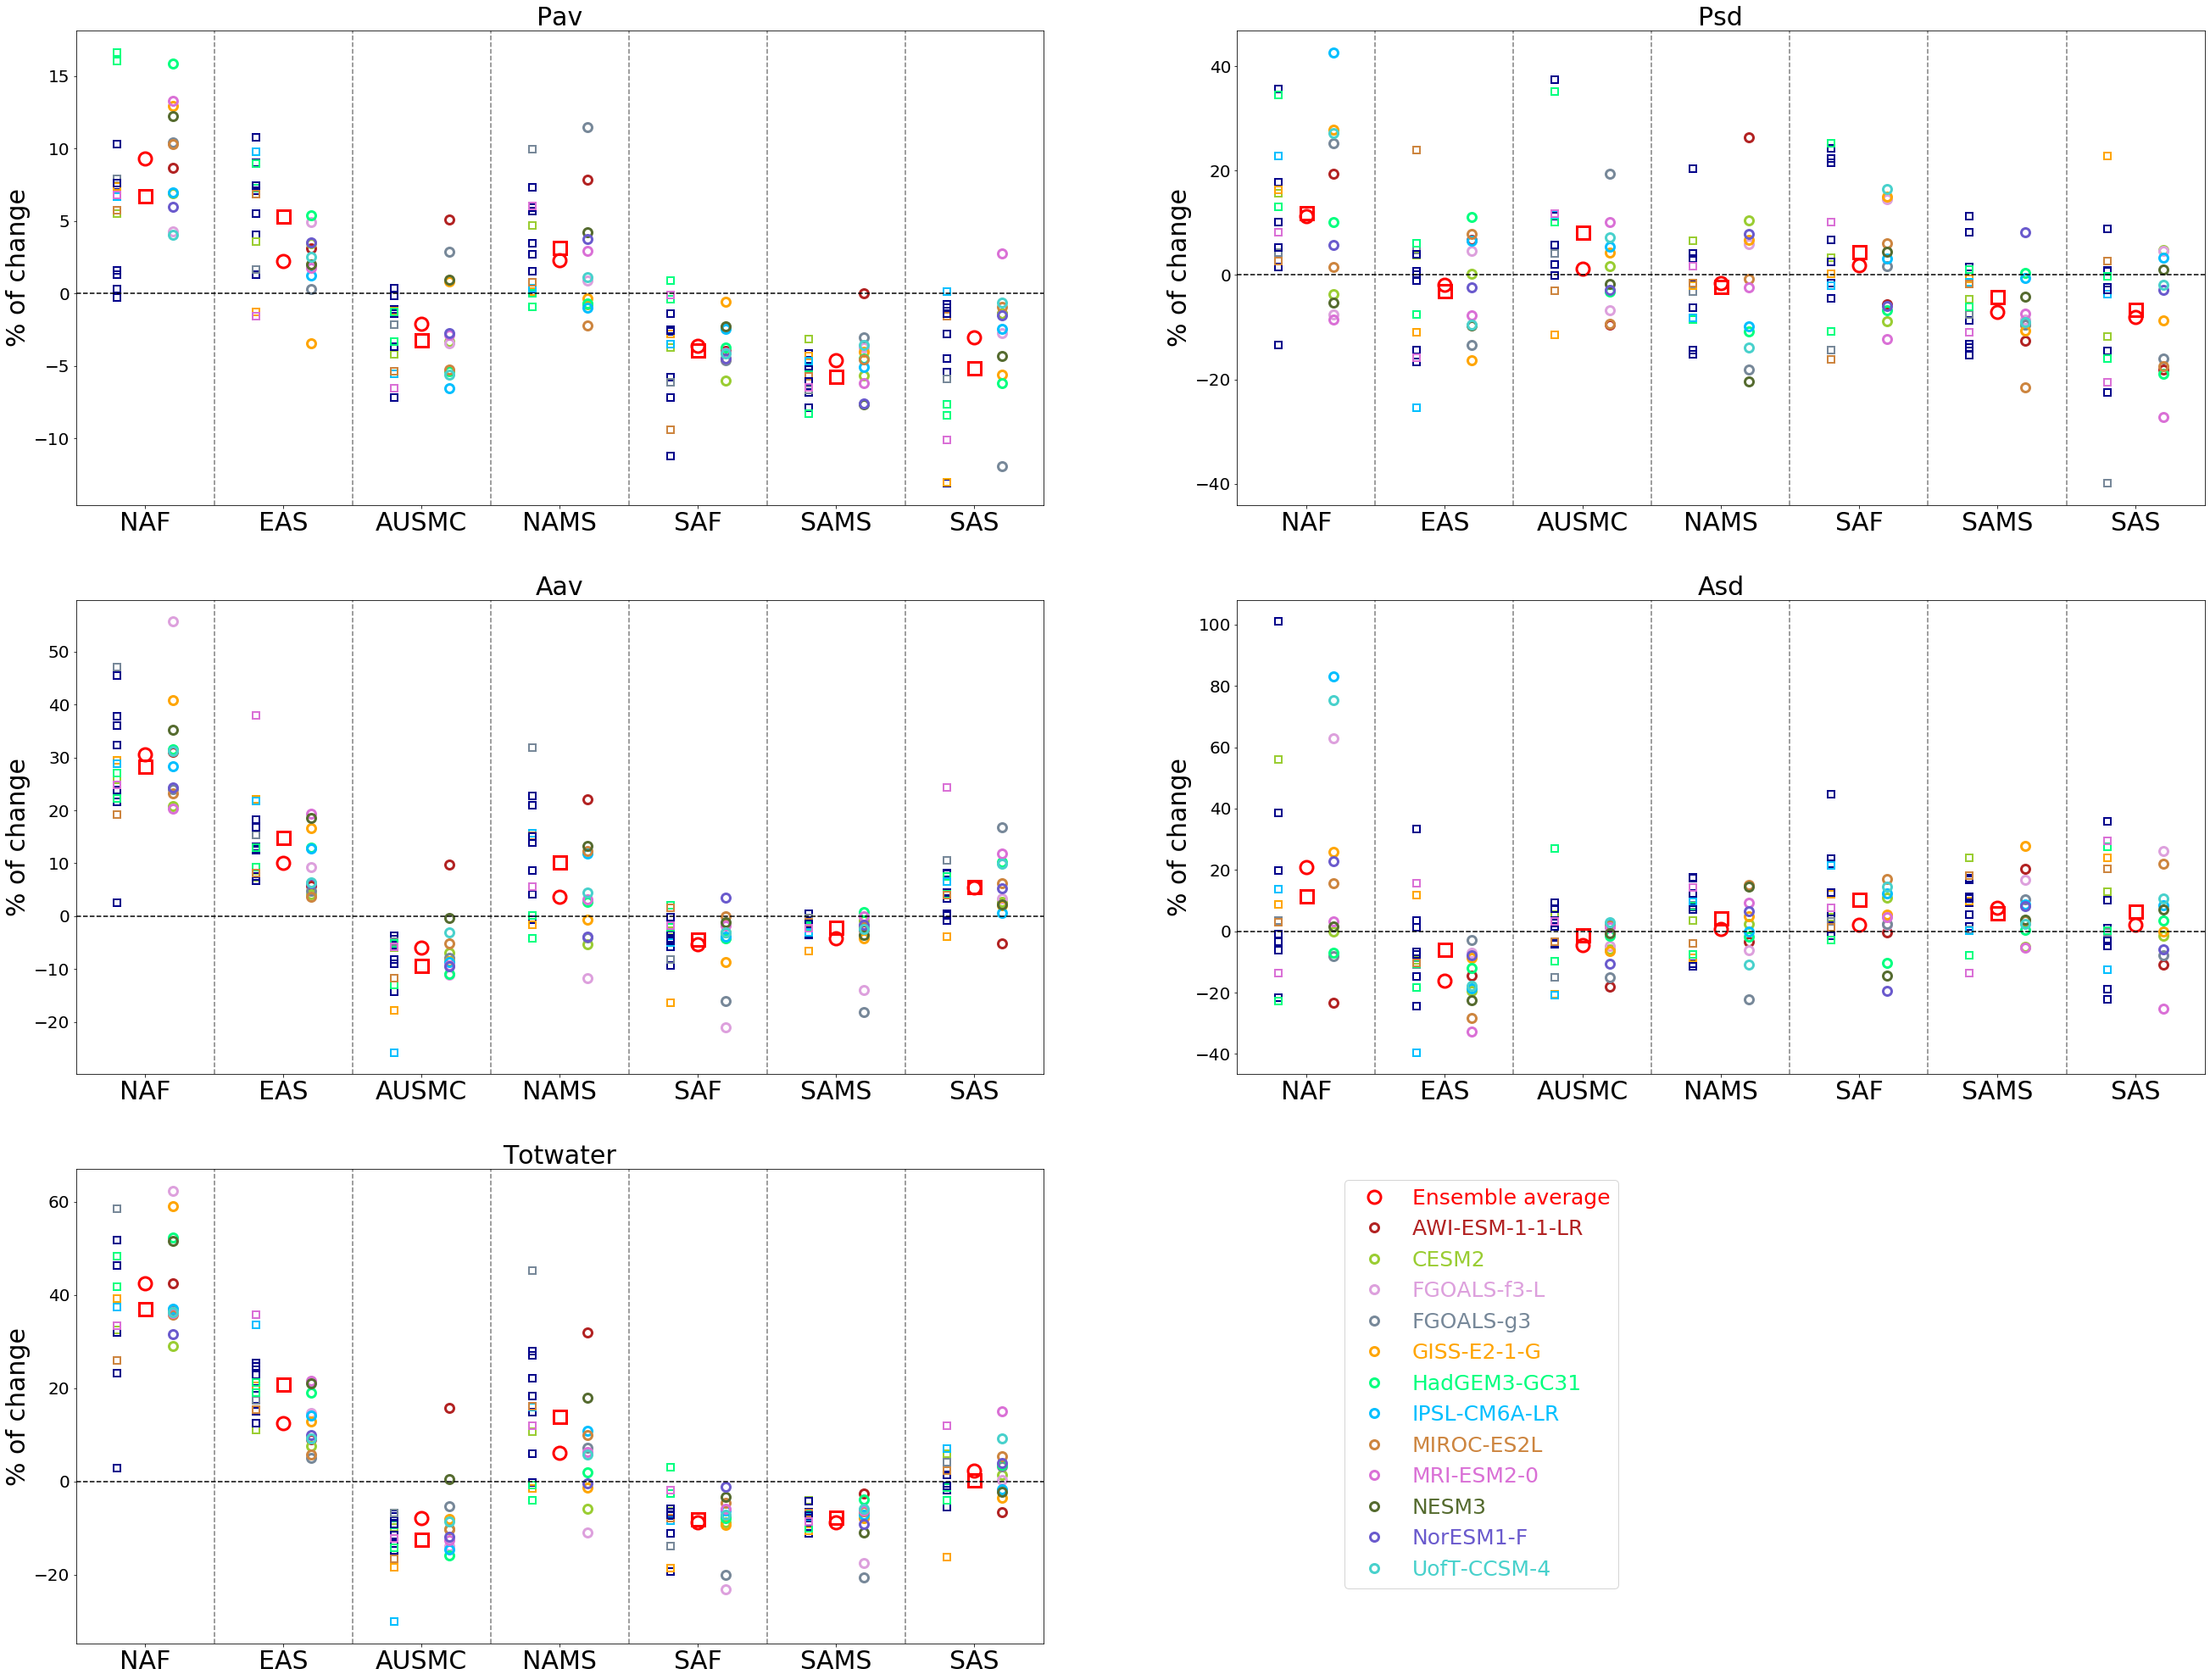

In [6]:
p1=[0.3,1.3,2.3,3.3,4.3,5.3,6.3]
p2=[0.7,1.7,2.7,3.7,4.7,5.7,6.7]
p3=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
lines=[1,2,3,4,5,6]
monsoonlist=['NAF','EAS','AUSMC','NAMS','SAF','SAMS','SAS',]
var=monsoonlist
colorst =['firebrick','yellowgreen','plum','lightslategray','orange','springgreen','deepskyblue','peru','orchid','darkolivegreen','slateblue','mediumturquoise']
colorst3=['darkblue','yellowgreen','darkblue','darkblue','darkblue','darkblue','lightslategray','darkblue','orange','springgreen','springgreen','deepskyblue','peru','darkblue','orchid']

plt.figure(figsize=(45,35))
#pav
plt.subplot(321)
plt.title('Pav',fontsize=30)
plt.xlim((0,7))
plt.plot(p3,df3pav['average'],marker='s', color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list3)):
    plt.plot(p1,df3pav[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p3,df4pav['average'],marker='o',color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list4)):
    plt.plot(p2,df4pav[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")


plt.subplot(322)
plt.title('Psd',fontsize=30)
plt.xlim((0,7))
plt.plot(p3,df3psd['average'],marker='s', color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list3)):
    plt.plot(p1,df3psd[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p3,df4psd['average'],marker='o',color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list4)):
    plt.plot(p2,df4psd[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")

plt.subplot(323)
plt.title('Aav',fontsize=30)
plt.xlim((0,7))
plt.plot(p3,df3aav['average'],marker='s', color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list3)):
    plt.plot(p1,df3aav[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p3,df4aav['average'],marker='o',color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list4)):
    plt.plot(p2,df4aav[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")


plt.subplot(324)
plt.title('Asd',fontsize=30)
plt.xlim((0,7))
plt.plot(p3,df3asd['average'],marker='s', color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list3)):
    plt.plot(p1,df3asd[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p3,df4asd['average'],marker='o',color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list4)):
    plt.plot(p2,df4asd[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")

plt.subplot(325)
plt.title('Totwater',fontsize=30)
plt.xlim((0,7))
plt.plot(p3,df3water['average'],marker='s', color='r',mew=3,ms=15,linestyle='None',fillstyle='none')
for i in range(len(model_list3)):
    plt.plot(p1,df3water[model_list3[i]],marker='s', color=colorst3[i],fillstyle='none',mew=2, ms=8,linestyle='None')
plt.plot(p3,df4water['average'],marker='o',color='r',mew=3,ms=15,linestyle='None',fillstyle='none',label='Ensemble average')
for i in range(len(model_list4)):
    plt.plot(p2,df4water[model_list4[i]],marker='o',color=colorst[i],fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.tick_params(labelsize=20)
plt.xticks(p3,var,fontsize=30)
plt.ylabel('% of change',fontsize=30)
for i in lines:
    plt.axvline(x=i,color='grey',linestyle="--",linewidth=1.5)
plt.axhline(y=0,color='k',linestyle="--")
leg=plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0.5,fontsize=25)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())


